In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from pylab import rcParams
import seaborn as sns
from collections import defaultdict

import networkx as nx
import community 

import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer, normalize
from nltk.corpus import stopwords

from collections import Counter
import re

%matplotlib inline
rcParams['figure.figsize'] = 12, 18

/Users/hal/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Read emails

In [2]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv")
emailRecevier = pd.read_csv("hillary-clinton-emails/EmailReceivers.csv")

Replace all empty fields with 'nan'. In this task we use ExtractedSubject and ExtractedBodyText columns. After we clean it removing all non alphabetical chars

In [3]:
emails[['ExtractedSubject','ExtractedBodyText']] = emails[['ExtractedSubject','ExtractedBodyText']].fillna('nan')
emails.ExtractedSubject = emails.ExtractedSubject.apply(lambda x: re.sub('[^a-zA-Z\-]+', ' ', x))
emails.ExtractedBodyText = emails.ExtractedBodyText.apply(lambda x: re.sub('[^a-zA-Z\-]+', ' ', x))

Now we need to reconstract the ineraction usning sender and reciever IDs from the files  using EmailId

In [4]:
emailSender = emails[['Id', 'SenderPersonId']].copy()

In [5]:
joinemails = emailSender.merge(emailRecevier, how='left', left_on='Id', right_on='EmailId')

Drop the cases were ID of a person is not defined.

In [6]:
joinemails = joinemails[['SenderPersonId','PersonId']].dropna().astype(int)

Now we can build a Networkx graph and find communities. We also output the graph using the source code provided in example

In [7]:
G=nx.from_pandas_dataframe(joinemails, 'SenderPersonId','PersonId')

In [8]:
partition = community.best_partition(G)

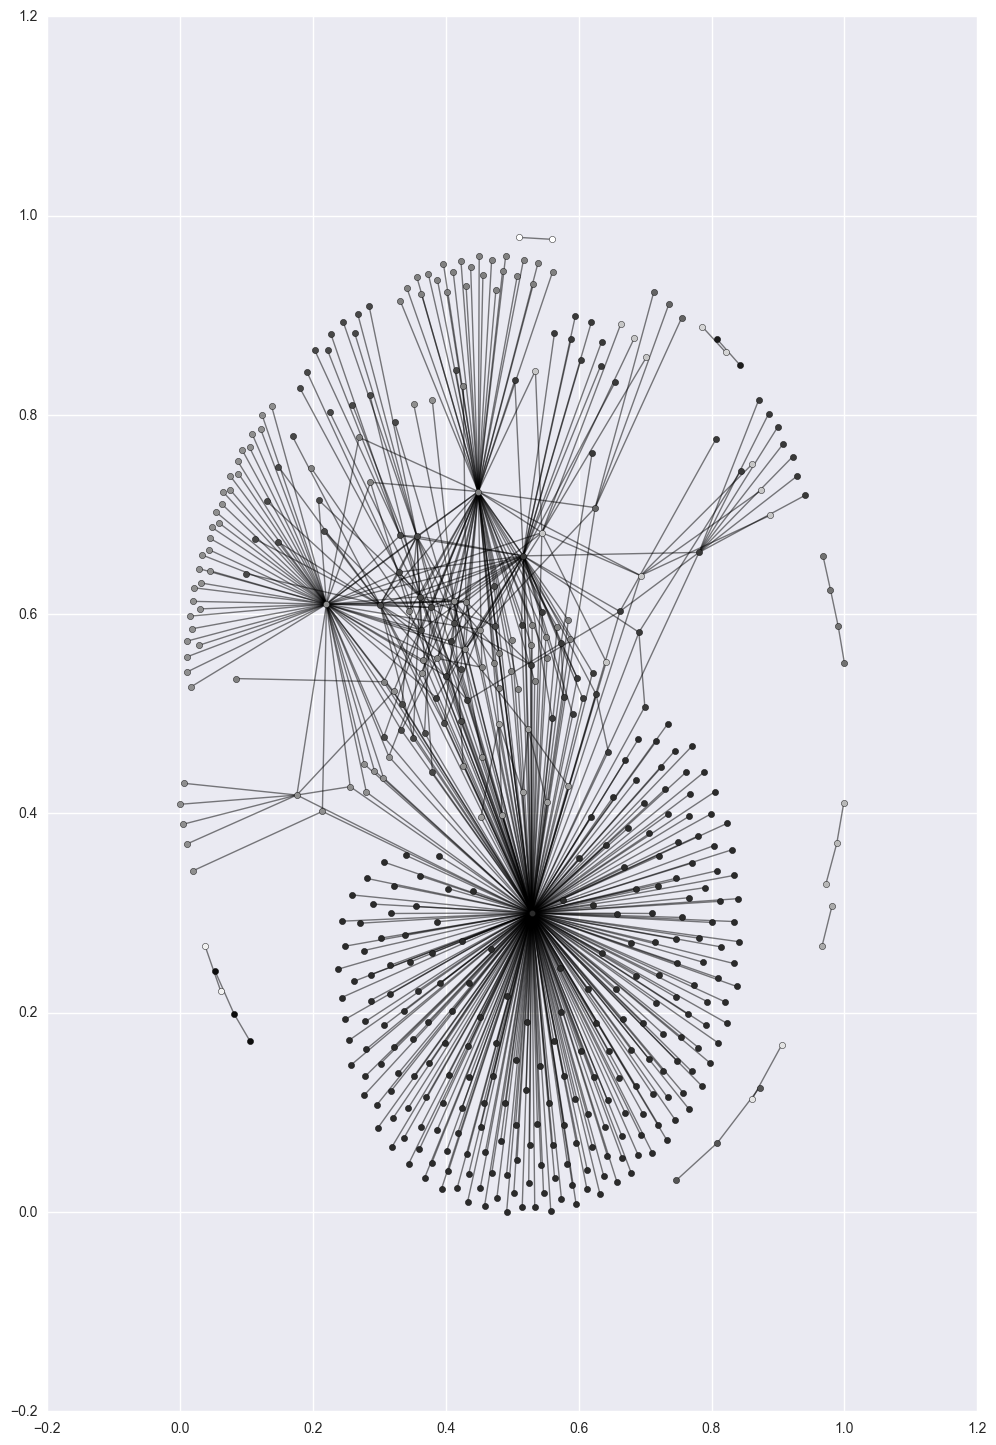

In [9]:
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                            node_color = str(count / size))
nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

Create a new DataFrame puting Person's ID and Community ID he belongs to

In [10]:
communities = pd.DataFrame(list(partition.items()), columns=['PersonId','CommunityId'])

Let's see how many communities and members per each we have

In [11]:
np.unique(communities.CommunityId, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 array([  3,   2, 238,  40,  41,   3,   4,   4,  49,  54,   7,   2,   3,
         10,   2,   2,   2,   2]))

Group all by community

In [12]:
emailscommunity = emails.merge(communities, left_on='SenderPersonId', right_on='PersonId')

In [13]:
emailscommunitygrouped = emailscommunity.groupby('CommunityId')

In [14]:
customstopwords = stopwords.words('english')
customstopwords = customstopwords + ['nan','call', 'know', 'would', 'get', 'time', 'work', 'like', 'today', 
                                     'see', 'morning', 'also', 'back', 'tomorrow', 'meeting', 'think', 
                                     'good', 'want', 'could', 'working', 'well', 'fw', 'fyi', 're', 'pm', 'h',
                                     'subject',
                                     'a','about','above','across','after','again','against','all','almost',
                                     'alone','along','already','also','although','always','among','an','and',
                                     'another','any','anybody','anyone','anything','anywhere','are','area',
                                     'areas','around','as','ask','asked','asking','asks','at','away','b','back',
                                     'backed','backing','backs','be','became','because','become','becomes','been',
                                     'before','began','behind','being','beings','best','better','between','big',
                                     'both','but','by','c','came','can','cannot','case','cases','certain',
                                     'certainly','clear','clearly','come','could','d','did','differ','different',
                                     'differently','do','does','done','down','down','downed','downing','downs',
                                     'during','e','each','early','either','end','ended','ending','ends','enough',
                                     'even','evenly','ever','every','everybody','everyone','everything',
                                     'everywhere','f','face','faces','fact','facts','far','felt','few','find',
                                     'finds','first','for','four','from','full','fully','further','furthered',
                                     'furthering','furthers','g','gave','general','generally','get','gets','give',
                                     'given','gives','go','going','good','goods','got','great','greater','greatest',
                                     'group','grouped','grouping','groups','h','had','has','have','having','he','her',
                                     'here','herself','high','high','high','higher','highest','him','himself','his',
                                     'how','however','i','if','important','in','interest','interested','interesting',
                                     'interests','into','is','it','its','itself','j','just','k','keep','keeps','kind',
                                     'knew','know','known','knows','l','large','largely','last','later','latest',
                                     'least','less','let','lets','like','likely','long','longer','longest','m',
                                     'made','make','making','man','many','may','me','member','members','men',
                                     'might','more','most','mostly','mr','mrs','much','must','my','myself',
                                     'n','necessary','need','needed','needing','needs','never','new','new',
                                     'newer','newest','next','no','nobody','non','noone','not','nothing',
                                     'now','nowhere','number','numbers','o','of','off','often','old','older',
                                     'oldest','on','once','one','only','open','opened','opening','opens','or',
                                     'order','ordered','ordering','orders','other','others','our','out','over',
                                     'p','part','parted','parting','parts','per','perhaps','place','places',
                                     'point','pointed','pointing','points','possible','present','presented',
                                     'presenting','presents','problem','problems','put','puts','q','quite','r',
                                     'rather','really','right','right','room','rooms','s','said','same','saw',
                                     'say','says','second','seconds','see','seem','seemed','seeming','seems',
                                     'sees','several','shall','she','should','show','showed','showing','shows',
                                     'side','sides','since','small','smaller','smallest','so','some','somebody',
                                     'someone','something','somewhere','state','states','still','still','such',
                                     'sure','t','take','taken','than','that','the','their','them','then','there',
                                     'therefore','these','they','thing','things','think','thinks','this','those',
                                     'though','thought','thoughts','three','through','thus','to','today','together',
                                     'too','took','toward','turn','turned','turning','turns','two','u','under',
                                     'until','up','upon','us','use','used','uses','v','very','w','want',
                                     'wanted','wanting','wants','was','way','ways','we','well','wells','went','were',
                                     'what','when','where','whether','which','while','who','whole','whose','why',
                                     'will','with','within','without','work','worked','working','works','would','x',
                                     'y','year','years','yet','you','young','younger','youngest','your','yours','z']
def format(text):
    words = [w.lower() for w in text.split() if len(w)>3]
    wordswostop = [w for w in words if w not in customstopwords]
    return wordswostop

Finaly we can aggregate messages in each community, preprocess them and count top 20 terms per each group

In [15]:
top=20
cnt = Counter()
mostcmnwords = []
for com in np.unique(communities.CommunityId):
    text = ' '.join(emailscommunitygrouped.get_group(com)['ExtractedBodyText'].dropna())
    cnt.update(format(text))
    mostcmnwords.append(cnt.most_common(top))
    print('Community number {},'.format(com))
    print('Top {} words: {}'.format(top, cnt.most_common(top)))

Community number 0,
Top 20 words: []
Community number 1,
Top 20 words: []
Community number 2,
Top 20 words: [('clintonemail', 215), ('hrod', 215), ('print', 154), ('talk', 123), ('clinton', 100), ('monday', 78), ('discuss', 73), ('department', 71), ('obama', 70), ('china', 69), ('hope', 67), ('president', 63), ('sunday', 63), ('week', 63), ('hillary', 62), ('send', 62), ('office', 61), ('thank', 61), ('sent', 60), ('thanks', 60)]
Community number 3,
Top 20 words: [('clintonemail', 223), ('hrod', 215), ('department', 214), ('president', 195), ('house', 186), ('people', 183), ('agreement', 176), ('united', 166), ('secretary', 165), ('benghazi', 164), ('talk', 162), ('clinton', 159), ('print', 157), ('information', 156), ('security', 155), ('government', 153), ('date', 145), ('obama', 144), ('monday', 138), ('world', 132)]
Community number 4,
Top 20 words: [('women', 385), ('clinton', 354), ('department', 331), ('president', 317), ('house', 295), ('people', 293), ('secretary', 280), ('oba

On one hand number of comunities can be used for the good approximation of potential number of topics discovery using LDA, however using simple count approach does not have a direct match with what was found using LDA in task 3.
In our opinion it is very difficult to identify the right dominate thems inside communities as we do not low high frequency terms common to all emails.